## A Deep Learning Model for accurately predicting the overall emotion of the paragraph.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Resources

/content/drive/MyDrive/Resources


### Importing libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns                           
import matplotlib.pyplot as plt   
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import fasttext
from contractions import contraction_map
import string,re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Libraries for Deep Learning

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Bidirectional, SpatialDropout1D, Input, TimeDistributed, Flatten, LSTM, GRU, Dropout
from keras.models import Sequential, save_model, Model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint



### Data Preprocessing

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Resources/text_emotion.csv')

In [6]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [7]:
data.sentiment.value_counts() 

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

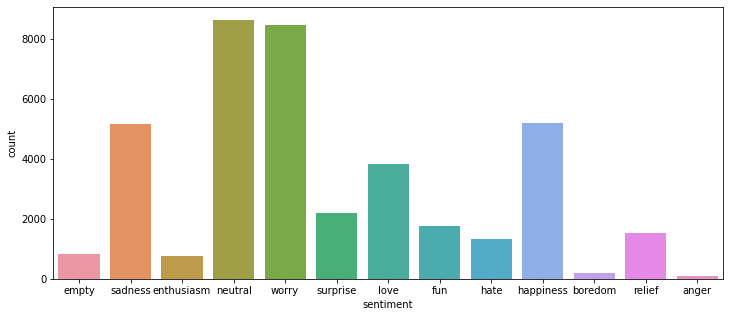

In [8]:
plt.figure(figsize=(12,5))
sns.countplot(x='sentiment', data = data)
plt.show()

In [9]:
df_temp = data.copy()

In [10]:
df_temp.dtypes

tweet_id      int64
sentiment    object
author       object
content      object
dtype: object

In [11]:
# Dropping rows with irrelevant emotion labels
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'boredom'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'enthusiasm'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'empty'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'fun'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'relief'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'surprise'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'love'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'hate'].index)

In [12]:
df_temp.sentiment.value_counts() 

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [13]:
df_temp

,tweet_id,sentiment,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
...,...,...,...,...
39992,1753918881,neutral,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,courtside101,Succesfully following Tayla!!
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor


In [14]:
df_temp = df_temp.drop('author',axis=1)
df_temp

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
39992,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,Succesfully following Tayla!!
39995,1753918954,neutral,@JohnLloydTaylor


In [15]:
df_temp.reset_index(drop=True,inplace=True)

In [16]:
df_temp.drop('tweet_id',axis=1,inplace=True)

In [17]:
df_temp.shape

(27581, 2)

In [18]:
df_temp.columns = ['sentiment','text']

In [19]:
df_temp.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [20]:
df_temp

,sentiment,text
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,neutral,@dannycastillo We want to trade with someone w...
3,worry,Re-pinging @ghostridah14: why didn't you go to...
4,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...
27576,neutral,@jasimmo Ooo showing of your French skills!! l...
27577,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
27578,happiness,Succesfully following Tayla!!
27579,neutral,@JohnLloydTaylor


### SMOTE For handling class imbalance

In [21]:
class_count_0, class_count_1, class_count_2, class_count_3, class_count_4 = df_temp.sentiment.value_counts()
class_count_anger_updated = df_temp[df_temp['sentiment'] == 'anger'].sample(class_count_3,replace=True)
class_count_anger_updated.reset_index(drop=True,inplace=True)

In [22]:
class_count_neutral = df_temp[df_temp['sentiment'] == 'neutral']
class_count_worry = df_temp[df_temp['sentiment'] == 'worry']
class_count_happiness = df_temp[df_temp['sentiment'] == 'happiness']
class_count_sadness= df_temp[df_temp['sentiment'] == 'sadness']

In [23]:
df = pd.concat([class_count_neutral,class_count_worry,class_count_happiness,class_count_sadness,class_count_anger_updated],axis=0) 

In [24]:
df.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
anger        5165
sadness      5165
Name: sentiment, dtype: int64

In [25]:
df

,sentiment,text
2,neutral,@dannycastillo We want to trade with someone w...
8,neutral,cant fall asleep
17,neutral,No Topic Maps talks at the Balisage Markup Con...
25,neutral,@cynthia_123 i cant sleep
26,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
5160,anger,@Buddy021193 i hear you.. it pisses me off haha
5161,anger,@paulmoxham everything is your fault moxy...ev...
5162,anger,@NerdIndian Take that back. I am insulted.
5163,anger,@paulmoxham everything is your fault moxy...ev...


In [26]:
df.reset_index(drop = True, inplace= True)

In [27]:
df

,sentiment,text
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
32631,anger,@Buddy021193 i hear you.. it pisses me off haha
32632,anger,@paulmoxham everything is your fault moxy...ev...
32633,anger,@NerdIndian Take that back. I am insulted.
32634,anger,@paulmoxham everything is your fault moxy...ev...


In [29]:
#Using Sentiment lexicons to be excluded from stopwords
df_pos = pd.read_csv('/content/drive/MyDrive/Resources/lexicons/negative.csv')
df_neg = pd.read_csv('/content/drive/MyDrive/Resources/lexicons/positive.csv')

### Data Cleaning

In [30]:
def expand_text(text):
    text = text.lower()
    text = text.replace("`","'")
    
    #Expand Contractions
    contraction_dict = contraction_map
    contraction_keys = list(contraction_dict.keys())
    
    for word in text.split():
        if word in contraction_keys:
            text = text.replace(word, contraction_dict[word])
        else:
            continue
    
    return text    

In [31]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    
    df_pos_words = list(df_pos.words)
    df_neg_words = list(df_neg.words)
    
    positive = []
    for i in range(0,len(df_pos_words)):
        positive.append(df_pos_words[i].lower().replace(" ",""))
        
    negative = []
    for i in range(0,len(df_neg_words)):
        negative.append(df_neg_words[i].lower().replace(" ",""))
        
    pos_set = set(positive)
    neg_set = set(negative)
    
    keywords = set(["above","and","below","not"])
    
    keywords.update(pos_set)
    keywords.update(neg_set)
    
    stopwords_set = set(stopwords.words('english'))
    stops = stopwords_set - keywords
    
    
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    text = re.sub(r"[^A-Za-z0-9^,!./\'+-=]"," ",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'s"," ",text)
    text = re.sub(r"\'ve"," have ",text)
    text = re.sub(r"n't"," not ",text)
    text = re.sub(r"i'm"," i am ",text)
    text = re.sub(r"\'re"," are ",text)
    text = re.sub(r"\'d", " would ",text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r","," ",text)
    text = re.sub(r"\."," ",text)
    text = re.sub(r"!"," ! ",text)
    text = re.sub(r"\/"," ",text)
    text = re.sub(r"\^"," ^ ",text)
    text = re.sub(r"\+"," + ",text)
    text = re.sub(r"\-"," - ",text)
    text = re.sub(r"\="," = ",text)
    text = re.sub(r"'"," ",text)
    text = re.sub(r"(\d+)(k)",r"\g<1>000",text)
    text = re.sub(r":", " : ",text)
    text = re.sub(r" e g "," eg ",text)
    text = re.sub(r"b g "," bg ",text)
    text = re.sub(r" u s "," american ",text)
    text = re.sub(r"\0s","0",text)
    text = re.sub(r"e - mail","email",text)
    text = re.sub(r"\s{2,}"," ",text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

In [32]:
df

,sentiment,text
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
32631,anger,@Buddy021193 i hear you.. it pisses me off haha
32632,anger,@paulmoxham everything is your fault moxy...ev...
32633,anger,@NerdIndian Take that back. I am insulted.
32634,anger,@paulmoxham everything is your fault moxy...ev...


In [33]:
df['text'] = df['text'].progress_apply(lambda x : expand_text(x))

In [34]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

In [36]:
df

,sentiment,text
0,neutral,dannycastillo want trade someone houston ticke...
1,neutral,cant fall asleep
2,neutral,topic map talk balisage markup conference 2009...
3,neutral,cynthia 123 cant sleep
4,neutral,missed bl y bus ! ! ! ! ! ! ! !
...,...,...
32631,anger,buddy021193 hear you piss haha
32632,anger,paulmoxham everything fault moxy everything x
32633,anger,nerdindian take back insulted
32634,anger,paulmoxham everything fault moxy everything x


In [37]:
df = df.sample(frac=1)

In [38]:
df.reset_index(drop=True,inplace=True)

In [39]:
df

,sentiment,text
0,happiness,loving phuket melai and badette coming home so...
1,neutral,uploaded run onto nikeplus com run row row run...
2,worry,feeling like want cry dont get empty feeling s...
3,worry,saharabloom not all !
4,sadness,mmmm ham yummy ! hat hair stupid deli
...,...,...
32631,anger,grabbing snack and drink chili power went out ...
32632,happiness,639 baby ! god sad really oh well life partaaa...
32633,worry,biggboymgmt alright alright ! tuning and takin...
32634,happiness,featureblend thanks intro great meet u twitter


### Create Tokenizer

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

34512


In [41]:
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences,maxlen=50)

### Word Embeddings Fasttext

In [42]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip

--2021-08-04 14:58:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560.65M  33.6MB/s    in 16s     

2021-08-04 14:58:43 (35.1 MB/s) - ‘wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]



In [43]:
!unzip wiki-news-300d-1M-subword.vec.zip

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


In [44]:
embeddings_index = {}
f = open('wiki-news-300d-1M-subword.vec',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype="float32")
    embeddings_index[word] = coefs
f.close()

### Create a weight matrix 

In [45]:
embedding_matrix = np.zeros((vocab_size,300))
for word,index in tokenizer.word_index.items():
    if index > vocab_size -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector 

### Model Building

In [46]:
max_len = 50

In [47]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10)
mc = ModelCheckpoint('./saved_models/best_model.h5',save_best_only=True,verbose=1)

In [48]:
df['sentiment'].value_counts()

neutral      8638
worry        8459
happiness    5209
anger        5165
sadness      5165
Name: sentiment, dtype: int64

### Test layers

In [49]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
model_lstm.add(LSTM(128,dropout=0.5))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(5,activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [50]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           10353600  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 10,596,753
Trainable params: 243,153
Non-trainable params: 10,353,600
_________________________________________________________________


In [51]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df['sentiment'])
labels = to_categorical(labels)

In [52]:
model_lstm.fit(data,labels,validation_split=0.1,epochs=20)

Epoch 1/20
918/918 [==============================] - 30s 9ms/step - loss: 1.4970 - accuracy: 0.3394 - val_loss: 1.2081 - val_accuracy: 0.4951
Epoch 2/20
918/918 [==============================] - 7s 8ms/step - loss: 1.2626 - accuracy: 0.4604 - val_loss: 1.0975 - val_accuracy: 0.5233
Epoch 3/20
918/918 [==============================] - 7s 7ms/step - loss: 1.1610 - accuracy: 0.4943 - val_loss: 1.0421 - val_accuracy: 0.5319
Epoch 4/20
918/918 [==============================] - 7s 7ms/step - loss: 1.0924 - accuracy: 0.5234 - val_loss: 1.0127 - val_accuracy: 0.5444
Epoch 5/20
918/918 [==============================] - 6s 7ms/step - loss: 1.0587 - accuracy: 0.5296 - val_loss: 1.0267 - val_accuracy: 0.5355
Epoch 6/20
918/918 [==============================] - 6s 7ms/step - loss: 1.0302 - accuracy: 0.5392 - val_loss: 1.0075 - val_accuracy: 0.5478
Epoch 7/20
918/918 [==============================] - 6s 7ms/step - loss: 1.0130 - accuracy: 0.5536 - val_loss: 0.9875 - val_accuracy: 0.5555
Epoch

In [53]:
txt = ["India Overtakes Russia As Third Worst-Hit Nation In COVID-19 Tally "]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model_lstm.predict(padded)
labels = ['anger',' happiness','neutral',' sadness','worry']
print(pred, labels[np.argmax(pred)])

[[6.7195608e-05 1.3772923e-01 2.5500989e-01 2.4744155e-01 3.5975212e-01]] worry


In [54]:
txt = ["Won the lottery! yay!"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model_lstm.predict(padded)
labels = ['anger',' happiness','neutral',' sadness','worry']
print(pred, labels[np.argmax(pred)])

[[0.00082181 0.57235074 0.19704863 0.07721471 0.15256411]]  happiness


In [55]:
fp = './saved_models/best_model.h5'
save_model(model_lstm,fp,include_optimizer=True)

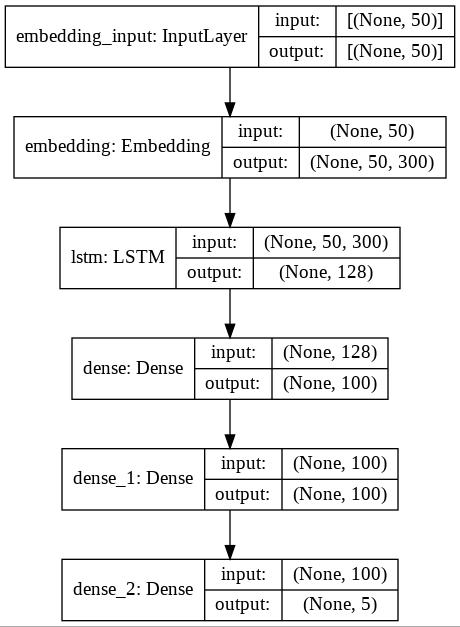

In [56]:
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='model_plot.jpeg', show_shapes=True, show_layer_names=True)

In [57]:
def create_nn():
  model = Sequential()
  model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
  model.add(LSTM(128,dropout=0.5))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(5,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

  return model


In [58]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df['sentiment'])
labels = to_categorical(labels)

### Evaluating neural network using three-fold cross-validation

In [59]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier


neural_network = KerasClassifier(build_fn=create_nn, 
                                 epochs=20,  
                                 verbose=0)

cross_val_score(neural_network,data, labels, cv=3)

array([0.56025368, 0.5492233 , 0.55184776])